# 1. Project Background

Airbnb made a historic rise in the past decade by allowing everyday homeowners to rent out their homes on their platform. This revolutionized the way people traveled and has become to the go to for many travelers. As we all know for many renters price plays a big factor in the decision making process. So for the host its important that they get the price correct so they can remain competitive with other renters in their area. As of now Airbnb provides with their own recommender system on how they should price their listing. But, with no information on how this is created host have very little knowledge on why they should price their home at a certain price point. So by creating a price predictor, I'm hoping to provide host with a clearer view on what goes into the price. 

# 2. The Dataset 

My dataset was pulled from insideairbnb.com a website that provides scraped data directly from the airbnb website. The dataset was last scraped on November 18th 2019 and contains the information that was avaible that day. 

The dataset contains 24197 listing and is accompanied with over 106 columns. That provide a robust description of each lising. Another caveat to take note of is that the pricing information that is scraped is of the advertised sticker price and not what renters actually paid. But I believe that pricing is close enough that we can get a decently accurate price. 

In [131]:
# !pip install xgboost

In [309]:
# Importing required libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
from xgboost import plot_importance
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics

# Set plot preference
plt.style.use(style='ggplot')

In [185]:
cape_town = pd.read_csv('capetown.csv')
print(f'This dataset is {len(cape_town)}')
pd.set_option('display.max_columns', len(cape_town.columns))
pd.options.display.max_info_columns = 110
pd.set_option('display.max_rows', 100)

cape_town.head()

This dataset is 24197


C:\Users\Kwasi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (43,61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3191,https://www.airbnb.com/rooms/3191,2.019110e+13,11/26/2019,Malleson Garden Cottage,"This is a lovely, separate, self-catering cott...",Beautiful self catering luxury cottage in cent...,"This is a lovely, separate, self-catering cott...",none,"Mowbray is on the Southern Suburbs line, 6km (...","There are pets on the property. One cat, who w...",The train station is about 400m from the cotta...,Fully self-contained cottage with separate ent...,"I live in the main house on the property, and ...","There is no smoking in the cottage, but you ca...",NaN,NaN,https://a0.muscache.com/im/pictures/697022/385...,NaN,3754,https://www.airbnb.com/users/show/3754,Brigitte,10/21/2008,"Cape Town, Western Cape, South Africa",I'm single and love to travel and meeting peop...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/3754/profile_...,https://a0.muscache.com/im/users/3754/profile_...,NaN,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Southern Suburbs, Western Cape, South Africa",NaN,Ward 57,NaN,Southern Suburbs,Western Cape,7700,Cape Town,"Southern Suburbs, South Africa",ZA,South Africa,-33.94739,18.47600,t,Guesthouse,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",NaN,$692.00,"$4,419.00","$17,676.00",NaN,$221.00,2,$0.00,3,730,3,3,730,730,3.0,730.0,2 weeks ago,t,23,44,64,339,11/26/2019,48,7,5/31/2013,6/15/2019,97.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,NaN,t,f,moderate,f,f,1,1,0,0,0.61
1,13044,https://www.airbnb.com/rooms/13044,2.019110e+13,11/27/2019,JAMBO Guest House / Green Room,The Green Room at Jambo Guest House is a sligh...,"Jambo, which means hello in Swahili, is a gues...",The Green Room at Jambo Guest House is a sligh...,none,Green Point is a popular leisure district domi...,Very centrally situated and walking distance t...,A lot of big attractions are within walking di...,Guests will have access to their own private r...,Barry and Mina will be around to ensure you ha...,We expect our guests to be well behaved. Only ...,NaN,NaN,https://a0.muscache.com/im/pictures/1a1dd4ee-4...,NaN,50700,https://www.airbnb.com/users/show/50700,Barry & Mina,11/2/2009,"Cape Town, Western Cape, South Africa",We have been running multi Award Winning Jambo...,NaN,NaN,NaN

3.Data Cleaning 

Went ahead and dropped the text columns because NLP is beyond the scope of what I am trying to solve. 

In [186]:
#Dropping Text columns because no nlp will be used 
bounced_columns = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
cape = cape_town.drop(bounced_columns, axis=1)

Then went hunting for columns that had huge null values 

In [187]:
cape.isna().sum()

id                                                  0
experiences_offered                                 0
host_since                                         14
host_response_time                               6106
host_response_rate                               6106
host_acceptance_rate                            24197
host_is_superhost                                  14
host_listings_count                                14
host_total_listings_count                          14
host_has_profile_pic                               14
host_identity_verified                             14
street                                              0
neighbourhood                                   24197
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                    24197
city                                               62
state                                             311
zipcode                                           729
market                      

In [188]:
#Dropped columns with huge nullvalues 
cape.drop(['host_acceptance_rate','neighbourhood', 'neighbourhood_group_cleansed', 'square_feet','weekly_price','monthly_price','license','jurisdiction_names'],axis=1, inplace=True)

cape.set_index('id', inplace=True) #This allow me to join information on the id columns that identify each listing if needed. 

host_listings_count and host_total_listings_count are the same columns so im going to drop one. I will also drop the listings count that are splits for the data because that will not be needed with our analysis. 

In [189]:
print(sum((cape.host_listings_count == cape.host_total_listings_count) == False))
cape.loc[((cape.host_listings_count == cape.host_total_listings_count) == False)][:14]

14


,experiences_offered,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12715801,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cape Town, Western Cape, South Africa",Ward 58,Cape Town,Western Cape,7700,Cape Town,"Cape Town, South Africa",ZA,South Africa,-33.96779,18.48729,f,House,Entire home/apt,8,4.0,4.0,6.0,Real Bed,"{TV,Internet,Wifi,Pool,Kitchen,""Free parking o...","$4,198.00","$2,000.00",$300.00,8,$400.00,5,30,5,5,30,30,5.0,30.0,13 months ago,t,27,52,82,357,5,0,12/28/2016,1/8/2018,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.14
13985713,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cape Town, WC, South Africa",Ward 115,Cape Town,WC,8000,Cape Town,"Cape Town, South Africa",ZA,South Africa,-33.92039,18.42151,f,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",""Air conditioning"",Kitchen,""Fre...",$707.00,NaN,NaN,1,$0.00,2,1125,2,2,1125,1125,2.0,1125.0,3 months ago,t,0,0,0,177,99,0,12/3/2016,10/15/2018,91.0,9.0,10.0,9.0,9.0,9.0,9.0,f,t,f,moderate,f,f,1,1,0,0,2.73
14181407,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cape Town, Western Cape, South Africa",Ward 54,Cape Town,Western Cape,8060,Cape Town,"Cape Town, South Africa",ZA,South Africa,-33.91332,18.39480,t,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Free parking on pre...","$1,488.00","$3,000.00",$530.00,2,$0.00,1,1125,1,2,1125,1125,1.8,1125.0,today,t,17,40,70,270,58,17,9/4/2016,10/27/2019,86.0,9.0,8.0,9.0,9.0,9.0,9.0,f,t,f,strict_14_with_grace_period,f,f,1,1,0,0,1.48
15696049,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cape Town, Western Cape, South Africa",Ward 23,Cape Town,Western Cape,7441,Cape Town,"Cape Town, South Africa",ZA,South Africa,-33.79248,18.45999,f,Apartment,Entire home/apt,4,1.0,2.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...","$1,502.00","$2,500.00",$750.00,1,$0.00,2,1125,2,2,1125,1125,2.0,1125.0,33 months ago,t,20,41,71,346,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,strict_14_with_grace_period,f,f,2,2,0,0,NaN
16356661,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cape Town, Western Cape, South Africa",Ward 23,Cape Town,Western Cape,7441,Cape Town,"Cape Town, South Africa",ZA,South Africa,-33.79232,18.46043,f,Apartment,Entire home/apt,4,1.0,2.0,3.0,Real Bed,"{TV,Wifi,Pool,Kitchen,""Free parking on premise...","$1,296.00","$2,500.00",$750.00,1,$0.00,2,1125,2,2,1125,1125,2.0,1125.0,33 months ago,t,21,44,74,164,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f,2,2,0,0,NaN
18481854,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cape Town, Western Cape, South Africa",Ward 107,Cape Town,Western Cape,7441,Cape Town,"Cape Town, South Africa",ZA,South Africa,-33.82031,18.48574,t,Guest suite,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV

In [190]:
cape.drop(['host_total_listings_count', 
         'calculated_host_listings_count', 
         'calculated_host_listings_count_entire_homes', 
         'calculated_host_listings_count_private_rooms', 
         'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

Orginally wanted to keep the longtitude and latitude so I could plot them on a map but couldnt get geopandas to work but before i drop, I saw an example where I could save it to a dataframe for later use if i did use it. Will drop all other location variables except neigbourhood_cleansed which gives the name of the neigbourhoods in Cape Town. In which in this case is Wards. 

In [191]:
coordinates = cape[['latitude', 'longitude']]

In [192]:
#choosing which column to use to pick location 

#dropping location columns 
cape.drop(['zipcode', 
           'latitude', 
           'longitude', 
           'street',  
           'city', 
           'state', 
           'market', 
           'smart_location', 
           'country_code', 
           'country', 
           'is_location_exact'], axis=1, inplace=True)

In [193]:
#Experiences will be dropped because there is no category but one 
cape.experiences_offered.unique()

cape.drop(['experiences_offered'], axis=1, inplace=True)

In [194]:
cape2 = cape.copy()

In [195]:
cape2.replace({'f': 0, 't': 1}, inplace=True)

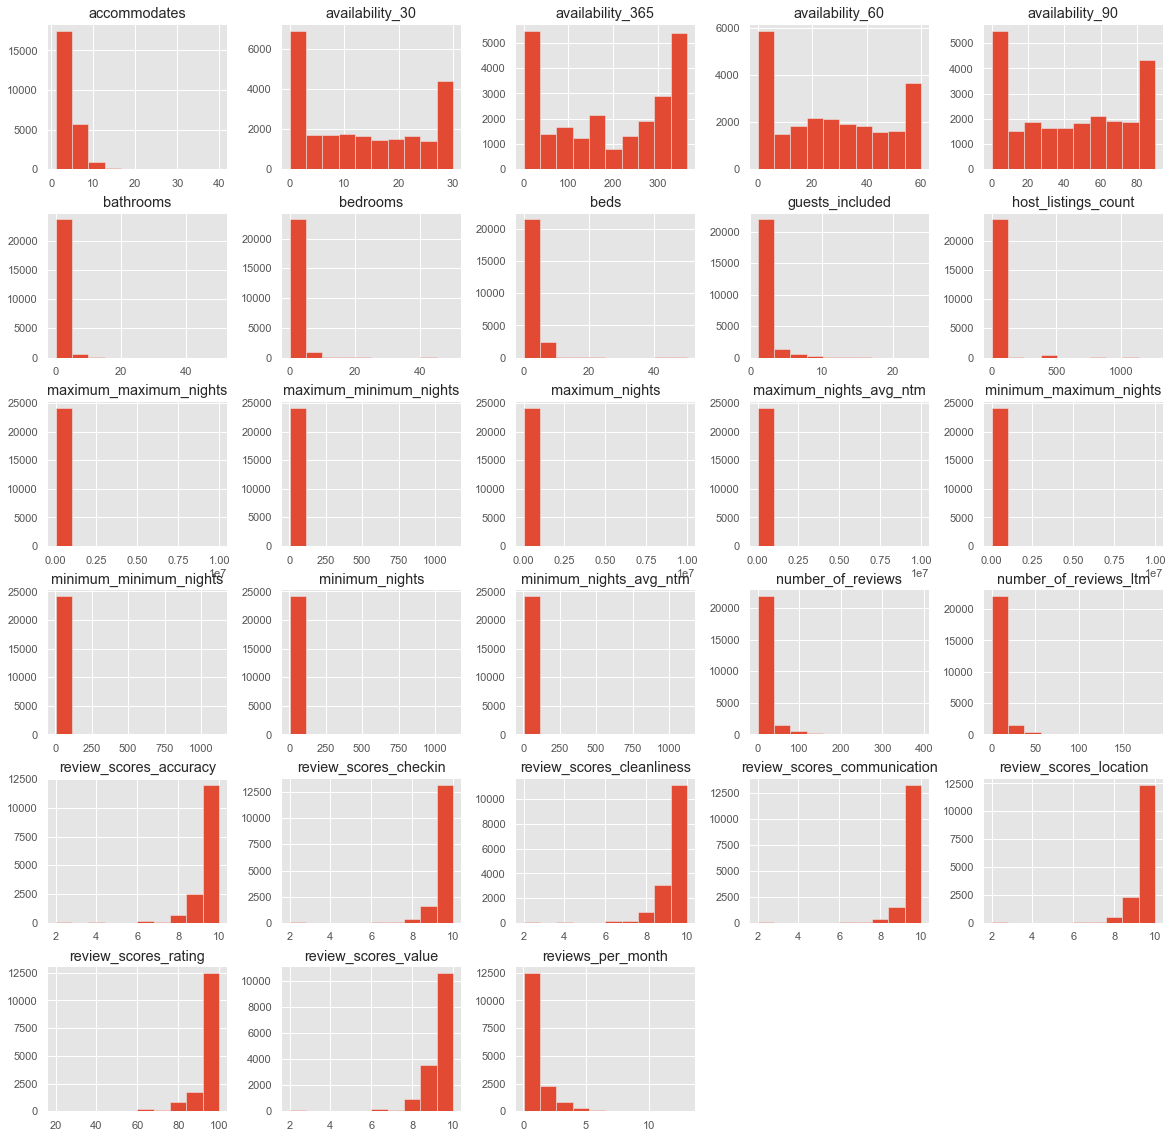

In [196]:
# Plotting the distribution of numerical and boolean categories
cape.hist(figsize=(20,20));

In [197]:
#Eliminated single category columns and jurisdiction names and square_feet which was missed earlier
cape.drop(['has_availability', 
           'host_has_profile_pic', 
           'is_business_travel_ready', 
           'require_guest_phone_verification', 
           'require_guest_profile_picture',
           'requires_license'], axis=1, inplace=True)

In [198]:
#dropping repetive information on maxium and minium nights 
cape.drop(['minimum_minimum_nights', 
           'maximum_minimum_nights', 
           'minimum_maximum_nights', 
           'maximum_maximum_nights', 
           'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

# Cleaning Individual Columns(Univarete Analysis) 

 Host_since

In [199]:


# Converting to datetime
cape.host_since = pd.to_datetime(cape.host_since) 

# Calculating the number of days
cape['host_days_active'] = (datetime(2019, 4, 9) - cape.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(cape['host_days_active'].mean(),0))
print("Median days as host:", cape['host_days_active'].median())

# Replacing null values with the median
cape.host_days_active.fillna(cape.host_days_active.median(), inplace=True)



Mean days as host: 1113.0
Median days as host: 1139.0


host_response_time

In [200]:
print("Null values:", cape.host_response_time.isna().sum())
print(f"Proportion: {round((cape.host_response_time.isna().sum()/len(cape))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
len(cape[cape.loc[ :,['host_response_time ', 'first_review'] ].isnull().sum(axis=1) == 2])

Null values: 6106
Proportion: 25.2%


C:\Users\Kwasi\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


8194

In [201]:
cape.host_response_time.fillna("unknown", inplace=True)
cape.host_response_time.value_counts(normalize=True)

within an hour        0.447617
unknown               0.252345
within a few hours    0.144233
within a day          0.122371
a few days or more    0.033434
Name: host_response_time, dtype: float64

In [202]:
print("Null values:", cape.host_response_rate.isna().sum())
print(f"Proportion: {round((cape.host_response_rate.isna().sum()/len(cape))*100, 1)}%")

Null values: 6106
Proportion: 25.2%


In [203]:
# Removing the % sign from the host_response_rate string and converting to an integer
cape.host_response_rate = cape.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(cape['host_response_rate'].mean(),0))
print("Median host response rate:", cape['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((cape.host_response_rate == 100.0).sum()/cape.host_response_rate.count())*100,1)}%")

Mean host response rate: 93.0
Median host response rate: 100.0
Proportion of 100% host response rates: 77.4%


In [204]:
# Bin into four categories
cape.host_response_rate = pd.cut(cape.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
cape.host_response_rate = cape.host_response_rate.astype('str')

# Replace nulls with 'unknown'
cape.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
cape.host_response_rate.value_counts()

100%       14005
unknown     6106
50-89%      1894
0-49%       1135
90-99%      1057
Name: host_response_rate, dtype: int64

host_is_superhost

In [205]:
# Number of rows without a value for multiple host-related columns
len(cape[cape.loc[ :,['host_since ', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 'host_identity_verified'] ].isnull().sum(axis=1) == 5])


14

columns that have a null for host realated columns will be dropped. iIn this case there is only 14 

In [206]:
cape.dropna(subset=['host_since'], inplace=True)

property_type 

Putting the property_types into 3 categories. 

In [207]:
cape.property_type.value_counts()

Apartment                 9567
House                     7314
Guest suite               1464
Villa                     1022
Guesthouse                 909
Condominium                642
Bed and breakfast          630
Townhouse                  593
Serviced apartment         508
Cottage                    422
Loft                       322
Boutique hotel             146
Bungalow                   142
Other                      112
Hostel                      74
Chalet                      58
Farm stay                   51
Aparthotel                  33
Tiny house                  32
Hotel                       32
Cabin                       29
Earth house                 13
Nature lodge                12
Resort                       7
Camper/RV                    7
Boat                         6
Barn                         5
Tipi                         5
Dorm                         4
Hut                          4
Casa particular (Cuba)       3
Dome house                   3
Castle  

In [208]:
#This part was a bit subjective but wanted to classify the homes so I wouldnt have to deal with a huge amount of columns 

cape.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

In [209]:
#all the other homes will be looked as other 
cape.loc[~cape.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [210]:
cape['property_type']

id
3191            Other
13044           Other
15007           House
15077       Apartment
15180       Apartment
              ...    
40371247        House
40371249        Other
40371304        House
40373694    Apartment
40381558    Apartment
Name: property_type, Length: 24183, dtype: object

Bathroom,Beds,bedrooms 

In [211]:
# bathrooms                                         21
# bedrooms                                          18
# beds                                              68

#To deal with the few missing values when it comes beds, bathrooms, beds, missing values will be treated with median
#insteand of mean which may give us a float number which in terms of this you cant have 1.45 bathrooms in a house 

for col in ['bathrooms', 'bedrooms', 'beds']:
    cape[col].fillna(cape[col].median(), inplace=True)

Bed_type 

In [212]:
cape.bed_type.value_counts()

Real Bed         24150
Pull-out Sofa       17
Futon                8
Couch                4
Airbed               4
Name: bed_type, dtype: int64

In [213]:
#with the overwhelming amount of beds being a real bed it would be a useless indicator on predicting price. 

In [214]:
cape.drop('bed_type', axis=1, inplace=True)

Amenities 

In [215]:
# Example of amenities listed
cape.amenities[:1].values

array(['{TV,"Cable TV",Wifi,"Air conditioning",Kitchen,"Free parking on premises","Pets live on this property",Cat(s),"Other pet(s)","Buzzer/wireless intercom",Heating,Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit",Essentials,Shampoo,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50","Private entrance","Hot water",Microwave,"Coffee maker",Refrigerator,"Dishes and silverware","Cooking basics",Oven,Stove,"Single level home","BBQ grill","Patio or balcony","Garden or backyard","Luggage dropoff allowed","Long term stays allowed","Cleaning before checkout","Well-lit path to entrance","Host greets you"}'],
      dtype=object)

In [216]:
# Creating a set of all possible amenities
amenities_list = list(cape.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Alarm system',
 'Alfresco bathtub',
 'Alfresco shower',
 'Amazon Echo',
 'Apple TV',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Balcony',
 'Bar',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach chairs',
 'Beach essentials',
 'Beach view',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Blender',
 'Body soap',
 'Breakfast',
 'Breakfast bar',
 'Breakfast table',
 'Brick oven',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Ceiling fans',
 'Ceiling hoist',
 'Central air conditioning',
 'Changing table',
 'Charcoal barbeque',
 "Chef's kitchen",
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Computer',
 'Convection oven',
 'Cooking basics',
 'Courtyard',
 'Crib',
 'DVD playe



In the list above, some amenities are more important than others (e.g. a balcony is more likely to increase price than a fax machine), and some are likely to be fairly uncommon (e.g. 'Electric profiling bed'). Based on previous experience working in the Airbnb property management industry, and research into which amenities are considered by guests to be more important, a selection of the more important amenities will be extracted. These will be further investigated in the EDA section. For example, if it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in helping explain differences in prices.

The amenities chosen are (slashes indicate separate categories that can be combined):

    24-hour check-in
    Air conditioning/central air conditioning
    Amazon Echo/Apple TV/DVD player/game console/Netflix/projector and screen/smart TV (i.e. non-basic electronics)
    BBQ grill/fire pit/propane barbeque
    Balcony/patio or balcony
    Beach view/beachfront/lake access/mountain view/ski-in ski-out/waterfront (i.e. great location/views)
    Bed linens
    Breakfast
    Cable TV/TV
    Coffee maker/espresso machine
    Cooking basics
    Dishwasher/Dryer/Washer/Washer and dryer
    Elevator
    Exercise equipment/gym/private gym/shared gym
    Family/kid friendly, or anything containing 'children'
    Free parking on premises/free street parking/outdoor parking/paid parking off premises/paid parking on premises
    Garden or backyard/outdoor seating/sun loungers/terrace
    Host greets you
    Hot tub/jetted tub/private hot tub/sauna/shared hot tub/pool/private pool/shared pool
    Internet/pocket wifi/wifi
    Long term stays allowed
    Pets allowed/cat(s)/dog(s)/pets live on this property/other pet(s)
    Private entrance
    Safe/security system
    Self check-in
    Smoking allowed
    Step-free access/wheelchair accessible, or anything containing 'accessible'
    Suitable for events



In [217]:
cape.loc[cape['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
cape.loc[cape['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
cape.loc[cape['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
cape.loc[cape['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
cape.loc[cape['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
cape.loc[cape['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
cape.loc[cape['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
cape.loc[cape['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
cape.loc[cape['amenities'].str.contains('TV'), 'tv'] = 1
cape.loc[cape['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
cape.loc[cape['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
cape.loc[cape['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
cape.loc[cape['amenities'].str.contains('Elevator'), 'elevator'] = 1
cape.loc[cape['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
cape.loc[cape['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
cape.loc[cape['amenities'].str.contains('parking'), 'parking'] = 1
cape.loc[cape['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
cape.loc[cape['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
cape.loc[cape['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
cape.loc[cape['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
cape.loc[cape['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
cape.loc[cape['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
cape.loc[cape['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
cape.loc[cape['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
cape.loc[cape['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
cape.loc[cape['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
cape.loc[cape['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
cape.loc[cape['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

C:\Users\Kwasi\Anaconda3\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [218]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = cape.iloc[:,41:].columns
cape[cols_to_replace_nulls] = cape[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in cape.iloc[:,41:].columns:
    if cape[col].sum() < len(cape)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
cape.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
cape.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'high_end_electronics', 'gym', 'event_suitable']


In [219]:
cape.columns[40:]

Index(['air_conditioning', 'bbq', 'balcony', 'nature_and_views', 'bed_linen',
       'breakfast', 'tv', 'coffee_machine', 'cooking_basics', 'white_goods',
       'elevator', 'child_friendly', 'parking', 'outdoor_space',
       'host_greeting', 'hot_tub_sauna_or_pool', 'internet', 'long_term_stays',
       'pets_allowed', 'private_entrance', 'secure', 'self_check_in',
       'smoking_allowed', 'accessible'],
      dtype='object')

Price 

In [220]:
#removing the $ sign and converting price to float 
cape['price'] = pd.to_numeric(cape['price'].str.replace('[$,]',''))

#Converting rand to USD with current exchange rate 
cape['price']= cape['price'] *.069

In [221]:
#Rounding the nearest dollar amount because airbnb prices are often listed without decimal points. 
cape.price.round()

id
3191          48.0
13044        145.0
15007        141.0
15077         96.0
15180         39.0
             ...  
40371247      38.0
40371249      38.0
40371304    1242.0
40373694      55.0
40381558     145.0
Name: price, Length: 24183, dtype: float64

In [222]:
#converting price to datatype of float since they have all been rounded 
cape['price'] = cape.price.astype(int)

security_deposit 

In [223]:
cape['security_deposit'] = pd.to_numeric(cape['security_deposit'].str.replace('[$,]',''))

In [224]:
#Converting rand to USD with current exchange rate 
cape['security_deposit']= cape['security_deposit'] *.069

In [225]:
#Rounding the nearest dollar amount because airbnb prices are often listed without decimal points. 
cape.security_deposit.round()

id
3191           NaN
13044          0.0
15007        173.0
15077          NaN
15180          NaN
             ...  
40371247       NaN
40371249       NaN
40371304    2070.0
40373694     276.0
40381558     345.0
Name: security_deposit, Length: 24183, dtype: float64

In [226]:
#Nan are convert to 0 because to the best of our knowledge they are not charging anything 
cape.security_deposit.fillna(0, inplace=True)

In [227]:
#converting price to datatype of float since they have all been rounded 
cape['security_deposit'] = cape.security_deposit.astype(int)

Cleaning_fee

In [228]:
cape['cleaning_fee'] = pd.to_numeric(cape['cleaning_fee'].str.replace('[$,]',''))

In [229]:
cape['cleaning_fee'] = cape['cleaning_fee'] *.069

In [230]:
#Rounding the nearest dollar amount because airbnb prices are often listed without decimal points. 
cape.cleaning_fee.round()

id
3191        15.0
13044        0.0
15007       59.0
15077        NaN
15180       10.0
            ... 
40371247     NaN
40371249     NaN
40371304     0.0
40373694    24.0
40381558     0.0
Name: cleaning_fee, Length: 24183, dtype: float64

In [231]:
#Nan are convert to 0 because to the best of our knowledge they are not charging anything 
cape.cleaning_fee.fillna(0, inplace=True)
#converting price to datatype of float since they have all been rounded 
cape['cleaning_fee'] = cape.cleaning_fee.astype(int)

extra_people 

In [232]:
cape['extra_people'] = pd.to_numeric(cape['extra_people'].str.replace('[$,]',''))
cape['extra_people'] = cape['extra_people'] *.069
#Rounding the nearest dollar amount because airbnb prices are often listed without decimal points. 
cape.extra_people.round()
#Nan are convert to 0 because to the best of our knowledge they are not charging anything 
cape.extra_people.fillna(0, inplace=True)
#converting price to datatype of float since they have all been rounded 
cape['extra_people'] = cape.extra_people.astype(int)

Calendar_updated

In [233]:
cape.calendar_updated.nunique()

76

In [234]:
cape.calendar_updated.value_counts()

today            3755
3 months ago     1893
2 weeks ago      1848
a week ago       1689
2 months ago     1282
3 weeks ago      1277
4 weeks ago       958
yesterday         944
5 weeks ago       736
4 months ago      611
6 weeks ago       572
5 days ago        520
4 days ago        469
5 months ago      408
3 days ago        407
11 months ago     382
9 months ago      370
2 days ago        369
8 months ago      357
7 weeks ago       327
10 months ago     314
12 months ago     301
7 months ago      300
24 months ago     292
6 months ago      271
13 months ago     245
23 months ago     193
14 months ago     178
6 days ago        173
25 months ago     142
20 months ago     136
1 week ago        130
22 months ago     125
36 months ago     124
35 months ago     105
26 months ago     103
15 months ago     101
21 months ago      99
17 months ago      98
48 months ago      97
19 months ago      89
16 months ago      89
37 months ago      82
32 months ago      71
47 months ago      68
never     

There doesnt seem to be anything valuable that can be gained from this column so im going to just drop it. 

In [235]:
cape.drop('calendar_updated', axis=1, inplace=True)

Avability 

New law passed in South Africa that only allows 30 day concsecutive rentals so the other availbilities dont matter. 

In [236]:
cape.drop(['availability_60', 'availability_90', 'availability_365'], axis=1, inplace=True)

first_review and last_review

In [237]:

cape.first_review.isna().sum()/len(cape)

cape.review_scores_rating .isna().sum()/len(cape)

0.35888847537526364

In [238]:
cape.first_review = pd.to_datetime(cape.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
cape['time_since_first_review'] = (datetime(2019, 11, 27) - cape.first_review).astype('timedelta64[D]')

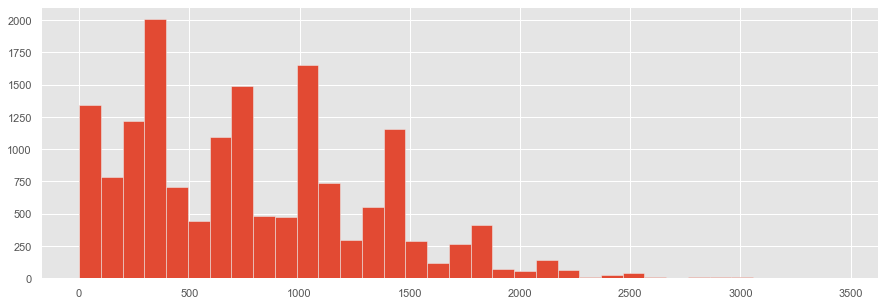

In [239]:
# Distribution of the number of days since first review
cape.time_since_first_review.hist(figsize=(15,5), bins=35);

In [240]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    cape[col] = pd.cut(cape[col], bins=bins, labels=labels, include_lowest=True)
    cape[col] = cape[col].astype('str')
    cape[col].fillna(na_label, inplace=True)

In [241]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(cape.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

Last_Review will also go through same process 

In [242]:
cape.last_review = pd.to_datetime(cape.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
cape['time_since_last_review'] = (datetime(2019, 4, 9) - cape.last_review).astype('timedelta64[D]')

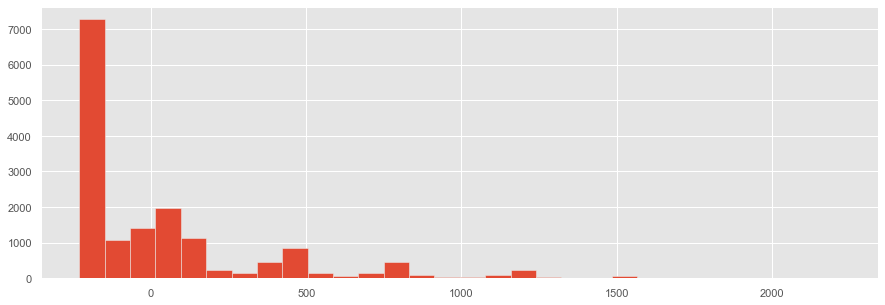

In [243]:
# Distribution of the number of days since last review
cape.time_since_last_review.hist(figsize=(15,5), bins=30);

In [244]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(cape.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

review ratings columns

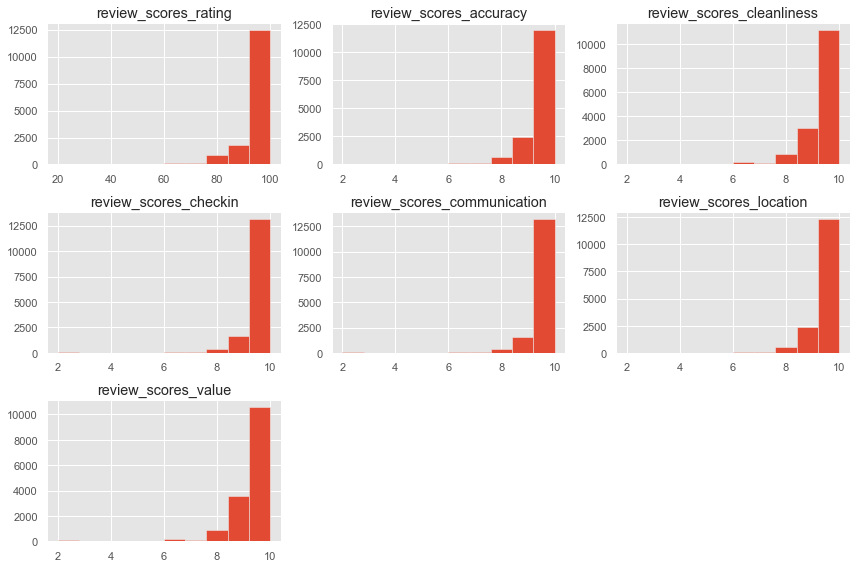

In [245]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(cape.columns[cape.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    cape[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [246]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

    # Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

cancellation_policy

In [247]:
cape.cancellation_policy.value_counts()

strict_14_with_grace_period    10433
flexible                        7555
moderate                        5508
super_strict_30                  538
super_strict_60                   89
luxury_moderate                   50
luxury_super_strict_95             7
strict                             3
Name: cancellation_policy, dtype: int64

In [248]:
# Replacing categories
cape.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate',
    'luxury_super_strict_95': 'strict_14_with_grace_period'
    }, inplace=True)

number_of_reviews_ltm and reviews_per_month

In [249]:
cape.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

In [251]:
cape.head()
cape.dtypes

host_since                     datetime64[ns]
host_response_time                     object
host_response_rate                     object
host_is_superhost                      object
host_listings_count                   float64
host_identity_verified                 object
neighbourhood_cleansed                 object
property_type                          object
room_type                              object
accommodates                            int64
bathrooms                             float64
bedrooms                              float64
beds                                  float64
price                                   int32
security_deposit                        int32
cleaning_fee                            int32
guests_included                         int64
extra_people                            int32
minimum_nights                          int64
maximum_nights                          int64
availability_30                         int64
number_of_reviews                 

# Exploratory data analysis


## Time Series

In [252]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(cape.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(cape.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 11 August 2008, and the most recent joined on 25 November 2019.


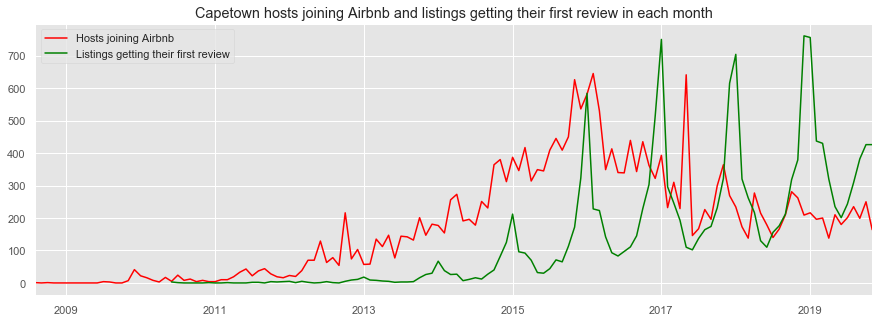

In [253]:
plt.figure(figsize=(15,5))
cape.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='red')
cape.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='green')
plt.title('Capetown hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2008-08-01', '2019-11-25') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [254]:
min(cape.host_since)

Timestamp('2008-08-11 00:00:00')

In [255]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(cape.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(cape.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [306]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

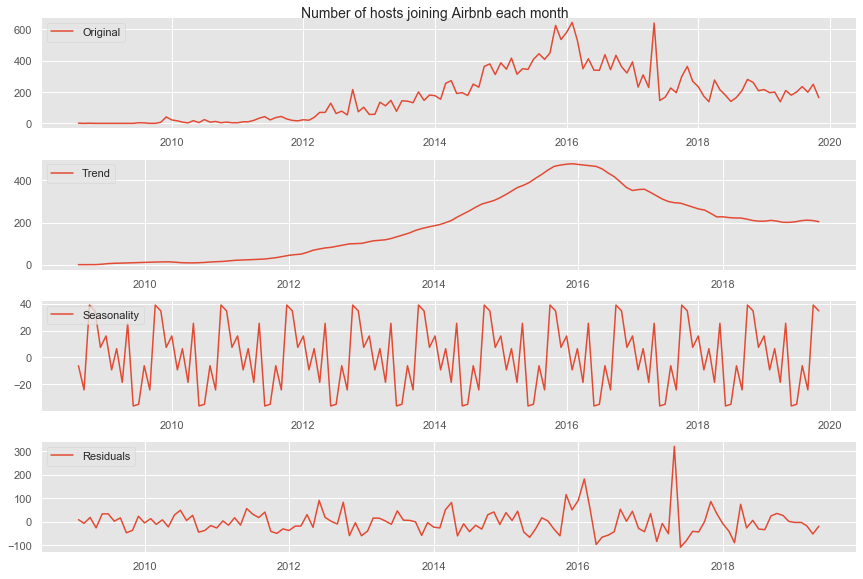

In [310]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

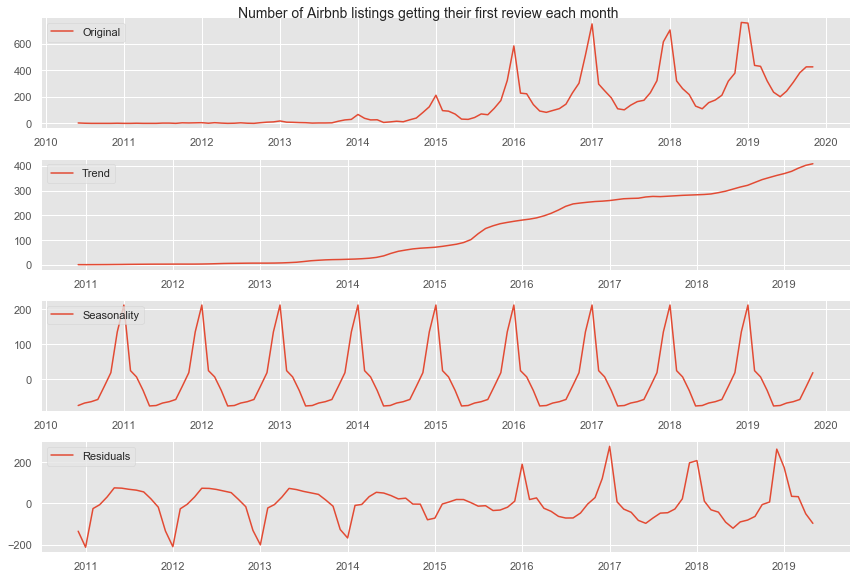

In [311]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

C:\Users\Kwasi\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Kwasi\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
C:\Users\Kwasi\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\Kwasi\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\Kwasi\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],


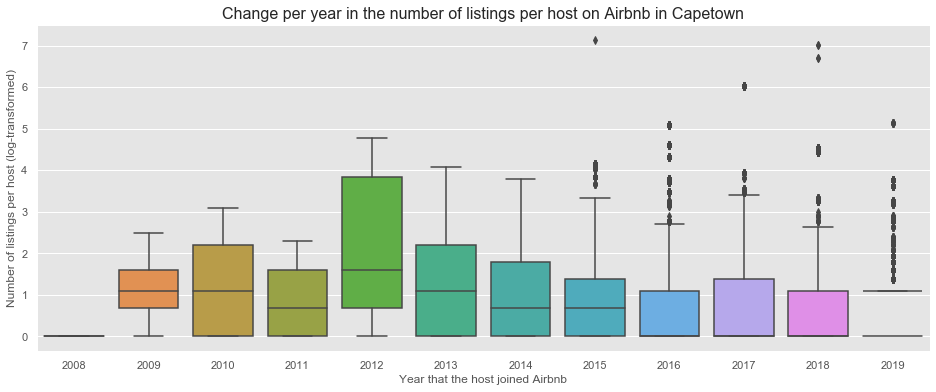

In [259]:
plt.figure(figsize=(16,6))
sns.boxplot(cape.host_since.dt.year, np.log(cape.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in Capetown', fontsize=16)
plt.show()



Question: how have prices changed over time?

Answer: the average price per night for Airbnb listings in Cape Town has increased slightly over the last 10 years. Even though the average price has take a hit since 2015 where the was $140.83, where as the mean price in 2019 was $116.14.


In [313]:


plt.figure(figsize=(16,6))
sns.boxplot(cape2.first_review.dt.year, np.log(cape.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in Capetown', fontsize=16)
plt.show()



AttributeError: Can only use .dt accessor with datetimelike values

<Figure size 1152x432 with 0 Axes>

In [261]:
print("Mean nightly price of listings in each year on Airbnb in Cape Town:")
print(round(cape.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in Cape Town:
first_review
2010-01-01     62.40
2011-01-01     95.62
2012-01-01     97.75
2013-01-01    107.64
2014-01-01    140.83
2015-01-01    119.66
2016-01-01    131.76
2017-01-01    119.03
2018-01-01    116.04
2019-01-01    116.86
Name: price, dtype: float64


In [262]:
# Dropping host_since and first_review as they are no longer needed
cape.drop(['host_since', 'first_review','last_review'], axis=1, inplace=True, errors='ignore')

In [263]:
cape.select_dtypes(include=['datetime64'])

""
id
3191
13044
15007
15077
15180
...
40371247
40371249
40371304


## Numerical Features 

In [264]:
cape.describe()

,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,number_of_reviews,host_days_active,air_conditioning,bbq,balcony,nature_and_views,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,accessible
count,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,2.418300e+04,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000,24183.000000
mean,14.508829,3.905636,1.739280,1.883927,2.409254,164.391308,116.423148,15.041351,1.603647,5.433817,3.817558,1.119451e+03,12.888930,12.769383,1112.555307,0.283877,0.225613,0.338047,0.129926,0.417607,0.116073,0.842741,0.273002,0.409420,0.737253,0.210892,0.386718,0.897614,0.243353,0.292520,0.496961,0.912128,0.359881,0.175826,0.461233,0.111442,0.130257,0.113634,0.126370
std,57.395632,2.426614,1.202213,1.421697,1.935254,476.311115,348.584679,28.235476,1.426673,14.367689,13.721543,6.430578e+04,10.951921,27.146803,705.430821,0.450887,0.417994,0.473055,0.336229,0.493175,0.320319,0.364053,0.445511,0.491737,0.440135,0.407950,0.487008,0.303161,0.429115,0.454929,0.500001,0.283114,0.479975,0.380680,0.498505,0.314685,0.336593,0.317372,0.332272
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,-230.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,1.000000,1.000000,1.000000,45.000000,0.000000,0.000000,1.000000,0.000000,1.000000,4.000000e+01,1.000000,0.000000,618.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,4.000000,1.000000,2.000000,2.000000,76.000000,0.000000,10.000000,1.000000,0.000000,2.000000,1.125000e+03,12.000000,2.000000,1139.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,5.000000,2.000000,3.000000,3.000000,138.000000,111.000000,24.000000,2.000000,6.000000,3.000000,1.125000e+03,23.000000,12.000000,1548.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1260.000000,40.000000,50.000000,50.000000,50.000000,20699.000000,17250.000000,2760.000000,24.000000,306.000000,1125.000000,1.000000e+07,30.000000,393.000000,3893.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Question: what is the overall distribution of prices?

Answer: nightly advertised prices range from $0 to $20,699. The extreme ends of the range are due to hosts not understanding how to use Airbnb advertised prices (sometimes called 'sticker' prices) correctly. The advertised prices can be set to any arbitrary amount, and these are the prices that show when dates are not entered on the site.

A model is only as good as its data, and unfortunately this model will be predicting advertised prices rather than the prices actually paid. Nevertheless, some cleaning of the particularly unhelpful values will be done. Very small values under $10 will be increased to $10.

There are notable drop-offs in nightly prices at $200 (first graph, orange line), $500 (second graph, orange line) and $1,000 (second graph, red line). Values above $1,000 will be reduced to $1,000.
    

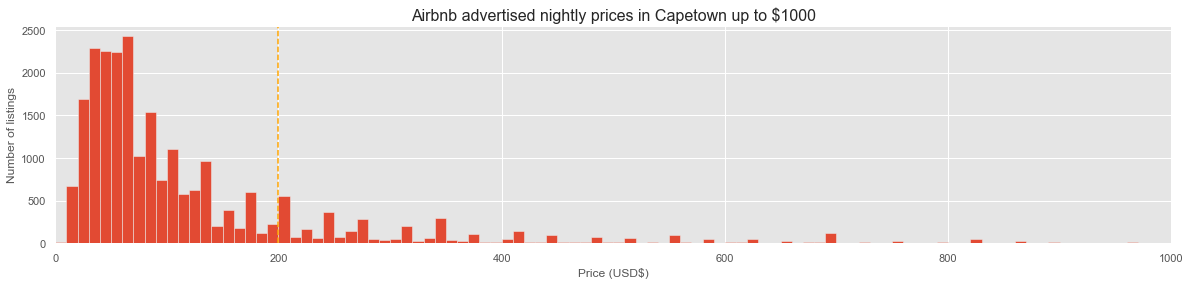

In [265]:
# Distribution of prices from $0 to $1000
plt.figure(figsize=(20,4))
cape.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in Capetown up to $1000", fontsize=16)
plt.xlabel("Price (USD$)")
plt.ylabel("Number of listings")
plt.show()

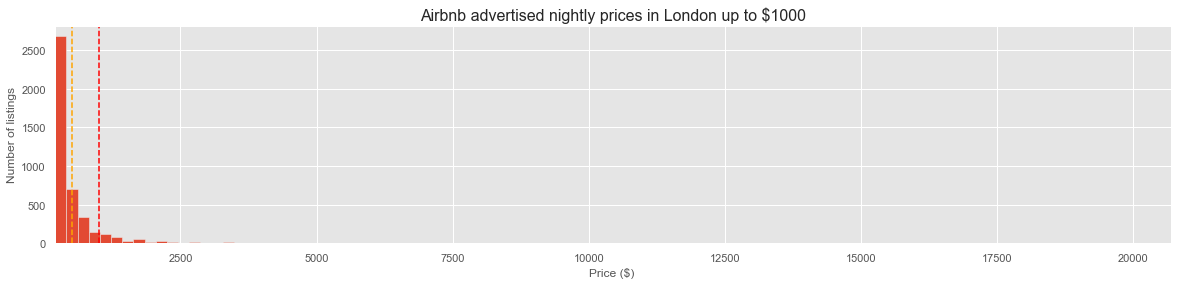

In [266]:
# Distribution of prices from $200 upwards
plt.figure(figsize=(20,4))
cape.price.hist(bins=100, range=(200, max(cape.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in Capetown up to $1000", fontsize=16)
plt.xlabel("Price ($) ")
plt.ylabel("Number of listings")
plt.show()

In [267]:
# Replacing values under $10 with $10
cape.loc[cape.price <= 10, 'price'] = 10

# Replacing values over $1000 with $1000
cape.loc[cape.price >= 1000, 'price'] = 1000



Host listings count


In [268]:
print("Median number of listings per host:", int(cape.host_listings_count.median()))
print("Mean number of listings per host:", int(round(cape.host_listings_count.mean())))
print(f"{int(round(100*len(cape[cape.host_listings_count == 1])/len(cape)))}% of listings are from hosts with one listing.")

Median number of listings per host: 2
Mean number of listings per host: 15
41% of listings are from hosts with one listing.


Number of people accommodated, bathrooms, bedrooms and beds

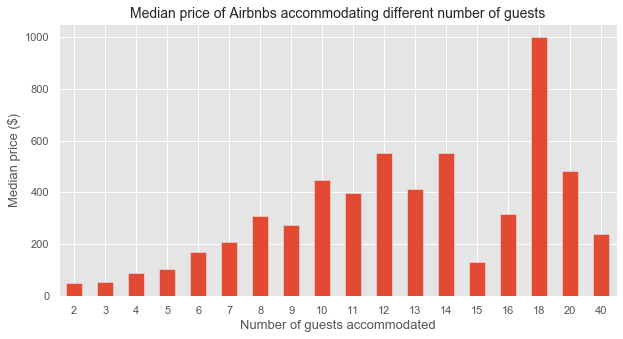

In [269]:
plt.figure(figsize=(10,5))
cape.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

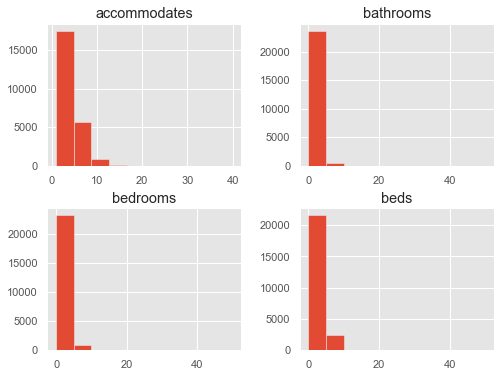

In [270]:
cape[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

## Categorical Features 

Categorical features will be explored and plotted, to gain insights and to determine whether or not they should be included in the final model.

Neighbourhood

Wanted to draw out maps but geopandas would not cooperate, but you will use boxplots to show that there is a difference in a where the home is situated. 

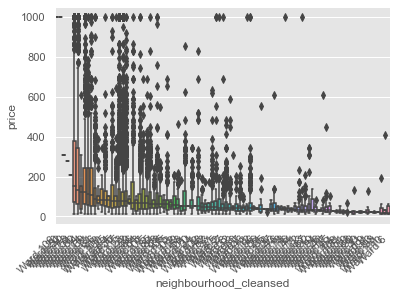

In [271]:
sort_price = cape.loc[(cape.price <= 1000) & (cape.price > 0)]\
                    .groupby('neighbourhood_cleansed')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='neighbourhood_cleansed', data=cape.loc[(cape.price <= 1000) & (cape.price > 0)], 
            order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

In [272]:

# See if neighbourhood has a significant influence 
cape.groupby('neighbourhood_cleansed').agg(
    [np.size,np.sum,np.mean, np.std])

host_listings_count                                   \
                                      size       sum       mean         std   
neighbourhood_cleansed                                                        
Ward 1                               248.0     613.0   2.471774    5.590551   
Ward 10                               33.0      25.0   0.757576    1.061553   
Ward 100                             351.0    1713.0   4.880342   10.276322   
Ward 101                               1.0       1.0   1.000000         NaN   
Ward 102                              62.0      93.0   1.500000    1.224745   
Ward 103                             100.0     138.0   1.380000    1.170168   
Ward 104                               2.0       0.0   0.000000    0.000000   
Ward 105                             143.0     362.0   2.531469    2.381869   
Ward 106                               1.0       1.0   1.000000         NaN   
Ward 107                             656.0    5636.0   8.591463   23.960289   
Ward 108                               7.0      18.0   2.571429    2.299068   
Ward 109                              52.0     154.0   2.961538    3.331146   
Ward 11                               46.0     117.0   2.543478    3.351328   
Ward 110                               5.0       6.0   1.200000    0.836660   
Ward 111                               8.0       6.0   0.750000    0.707107   
Ward 112                             129.0     250.0   1.937984    1.423859   
Ward 113                             345.0    1084.0   3.142029    9.880689   
Ward 115                            4232.0  158708.0  37.501890  100.337325   
Ward 116                               5.0       9.0   1.800000    1.303840   
Ward 12                                2.0       2.0   1.000000    0.000000   
Ward 14                               46.0     266.0   5.782609   24.822851   
Ward 15                              459.0    1118.0   2.435730    4.539216   
Ward 16                                4.0       4.0   1.000000    0.816497   
Ward 17                                7.0       7.0   1.000000    0.577350   
Ward 18                                2.0       2.0   1.000000    0.000000   
Ward 19                                8.0      19.0   2.375000    1.767767   
Ward 2                               140.0     340.0   2.428571    2.393465   
Ward 20                                1.0       0.0   0.000000         NaN   
Ward 21                              205.0     560.0   2.731707    4.243937   
Ward 22                                3.0       3.0   1.000000    0.000000   
Ward 23                             1298.0   13663.0  10.526194   26.319659   
Ward 24                                1.0       1.0   1.000000         NaN   
Ward 25                                4.0       2.0   0.500000    0.577350   
Ward 26                               21.0      19.0   0.904762    0.538958   
Ward 27                               35.0      54.0   1.542857    1.010034   
Ward 28                                2.0       3.0   1.500000    0.707107   
Ward 29                                5.0       3.0   0.600000    0.894427   
Ward 3                                81.0     416.0   5.135802   11.765153   
Ward 30                                4.0       6.0   1.500000    1.290994   
Ward 32                                6.0       5.0   0.833333    0.408248   
Ward 34                                1.0       1.0   1.000000         NaN   
Ward 4                               336.0    1428.0   4.250000    6.881730   
Ward 40                                1.0       1.0   1.000000         NaN   
Ward 41                                1.0       1.0   1.000000         NaN   
Ward 43                               11.0      12.0   1.090909    0.539360   
Ward 44                                3.0       3.0   1.000000    1.000000   
Ward 45                                1.0       1.0   1.000000         NaN   
Ward 46                               30.0     274.0   9.133333    7.4912

Property and room types

Question: what are the most common property and room types?

Answer: about 43% of properties are apartments. The remainder are houses or more uncommon property types (e.g. 'bed and breakfast' or 'yurt').

About 76% of listings are entire homes (i.e. you are renting the entire property on your own). Most of the remainder are private rooms (i.e. you are renting a bedroom and possibly also a bathroom, but there will be other people in the property). Fewer than 1% are shared rooms (i.e. you are sharing a room with either the property owner or other guests).

In [273]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    cape[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

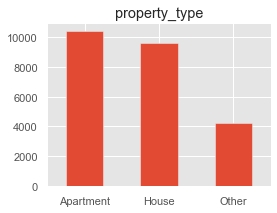

Apartment    0.42993
House        0.39627
Other        0.17380
Name: property_type, dtype: float64


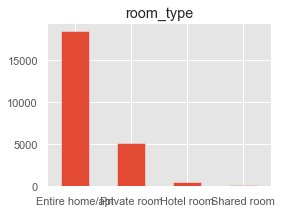

Entire home/apt    0.762643
Private room       0.210065
Hotel room         0.021751
Shared room        0.005541
Name: room_type, dtype: float64


In [274]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(cape[col].value_counts(normalize=True))

Reviews

Question: what is the distribution of reviews like?

Answer: for every review category, the majority of listings that have had a review have received a 10/10 rating for that category (or 95-100/100 overall).

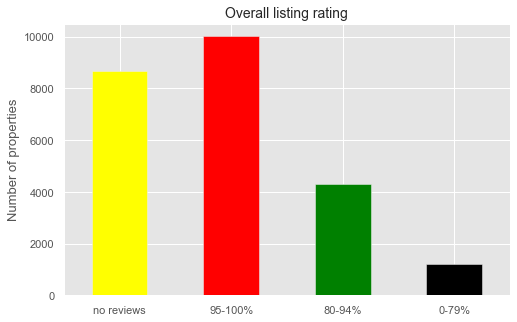

In [275]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('Overall listing rating', fontsize=14)
cape['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['yellow', 'red', 'green', 'black' ], ax=ax)
ax.set_xticklabels(labels=['no reviews', '95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Number of properties', fontsize=13)
plt.show()

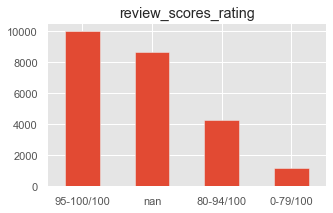

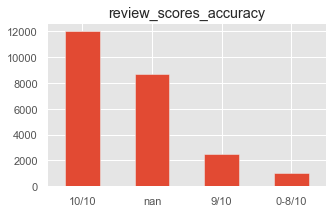

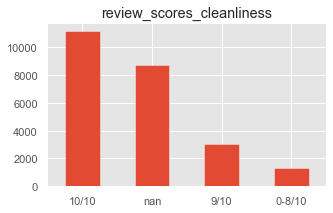

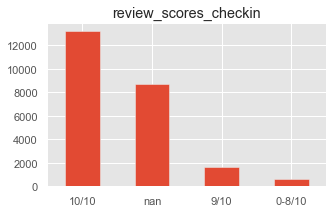

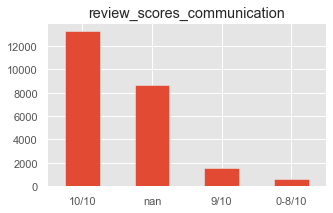

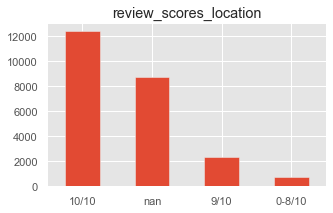

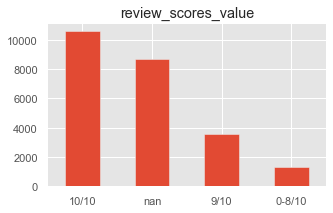

In [276]:
for col in list(cape.columns[cape.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

## Boolean (true or false) features 

In [277]:


def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    cape.groupby(col).size().plot(kind='bar', ax=ax1, color=['red', 'green'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    cape.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['red', 'green'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price ($)')
    ax2.set_xlabel('')
    
    plt.show()



Superhosts



Question: what proportion of Airbnb hosts are superhosts, and is it worth being one?

Answer: about 21% of hosts are superhosts. However, it does not seem to improve the median price per night of their Airbnb listings, so it is arguable whether or not it is worth it (from a financial perspective).


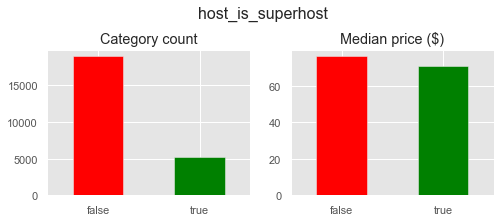

f    0.784353
t    0.215647
Name: host_is_superhost, dtype: float64


In [278]:
binary_count_and_price_plot('host_is_superhost')
print(cape.host_is_superhost.value_counts(normalize=True))

Host verification

Question: how many hosts are verified, and is it worth it? (a question often asked by hosts)

Answer: only about 27% of hosts are verified (e.g. by providing ID and verifying your phone number and email address), although it is something that hosts often think they are expected to do. Interestingly, however, despite the fact that one might expect the additional trust commanded by verified hosts to result in higher nightly prices, there is no real big difference between the median nightly prices of listings with verified and unverified hosts.

In [279]:
cape.host_identity_verified.value_counts(normalize=True)

f    0.72398
t    0.27602
Name: host_identity_verified, dtype: float64

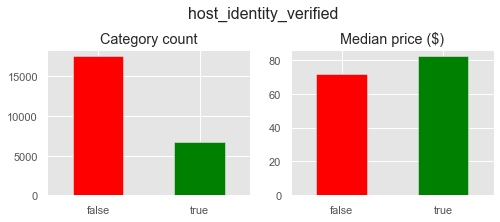

In [280]:
binary_count_and_price_plot('host_identity_verified')

Instant booking

Question: how many properties are instant bookable (i.e. able to be booked without messaging the host first), and is it worth it?

Answer: only about 52% of properties are instant bookable. However, the added convenience does not seem to have any effect on the median price per night.

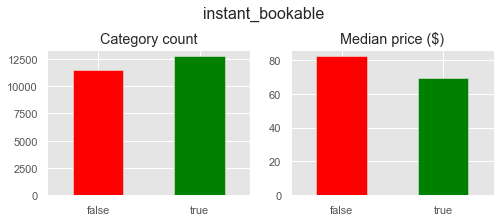

t    0.525493
f    0.474507
Name: instant_bookable, dtype: float64


In [281]:
binary_count_and_price_plot('instant_bookable')
print(cape.instant_bookable.value_counts(normalize=True))

Amenities

Question: which amenities are common, and which increase the price of an Airbnb listing?

High Impact Amenties 

1.Allowing customers to smoke diminishes the value of your property a decent amount 

2.Internet,Hot Tub,Pool great way to increase your price. 

3. AC is important 

4. BBQ

5.Balcony 

6.Nature views 
7.TV
8.Child Friendly 


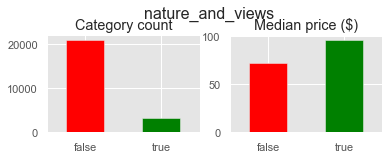

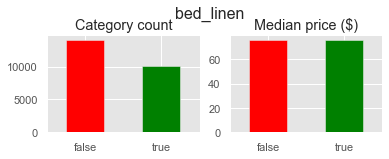

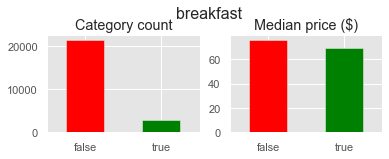

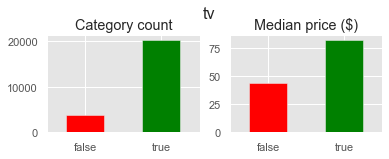

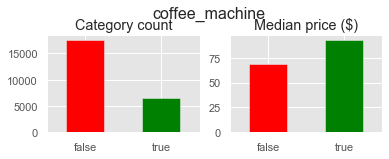

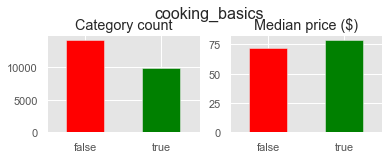

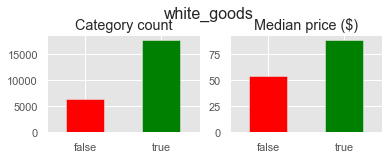

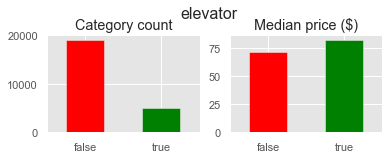

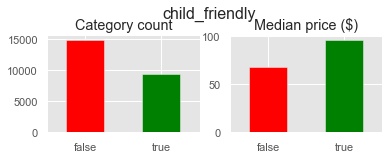

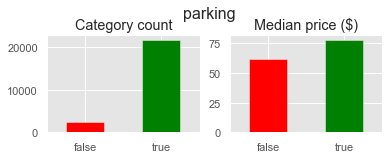

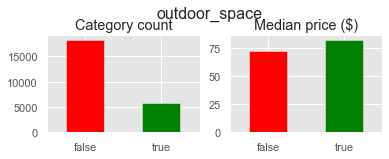

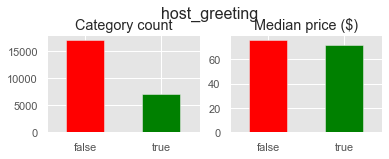

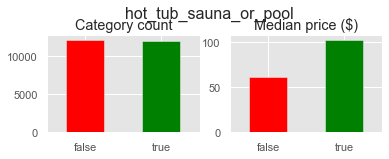

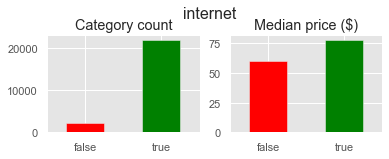

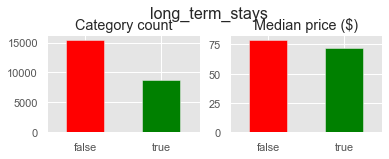

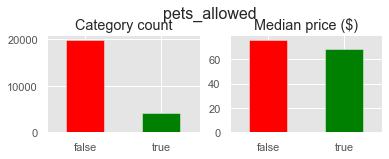

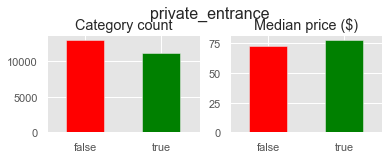

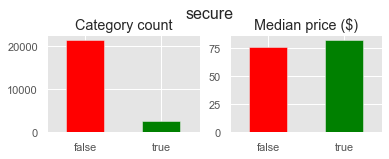

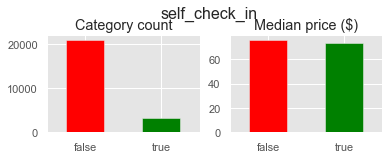

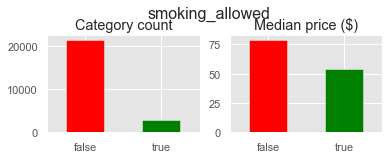

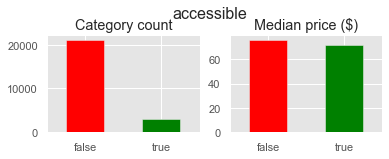

In [282]:
for col in cape.iloc[:,34:-2].columns:
    binary_count_and_price_plot(col, figsize=(6,2))

#  Preparing the data for modeling

In [283]:
transformed_df = pd.get_dummies(cape)

In [284]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

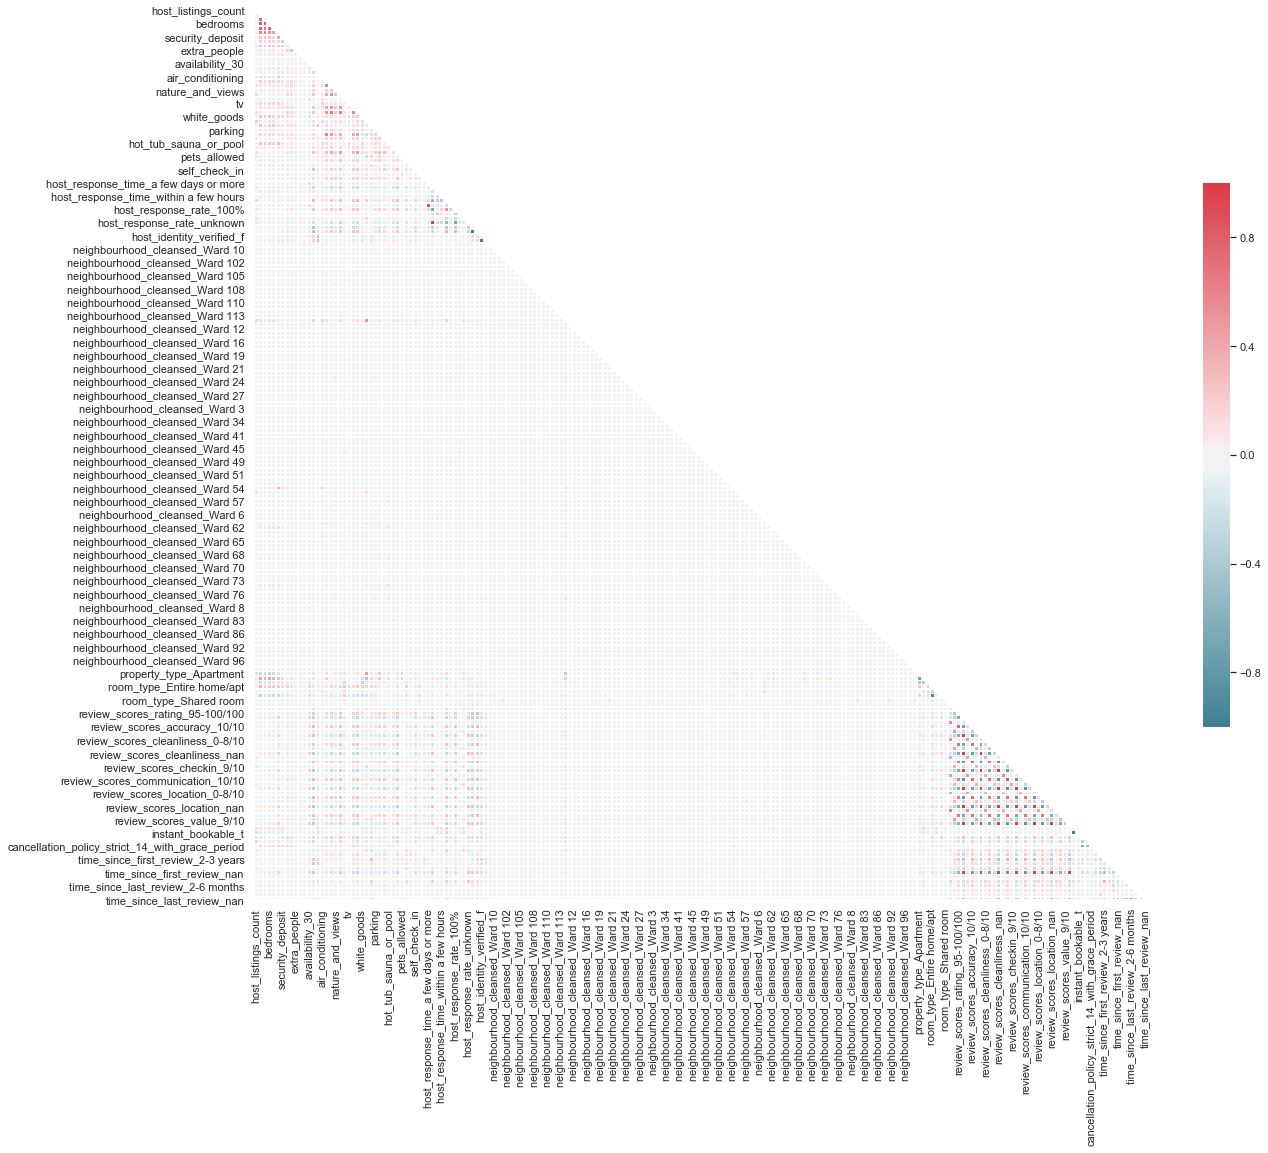

In [285]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

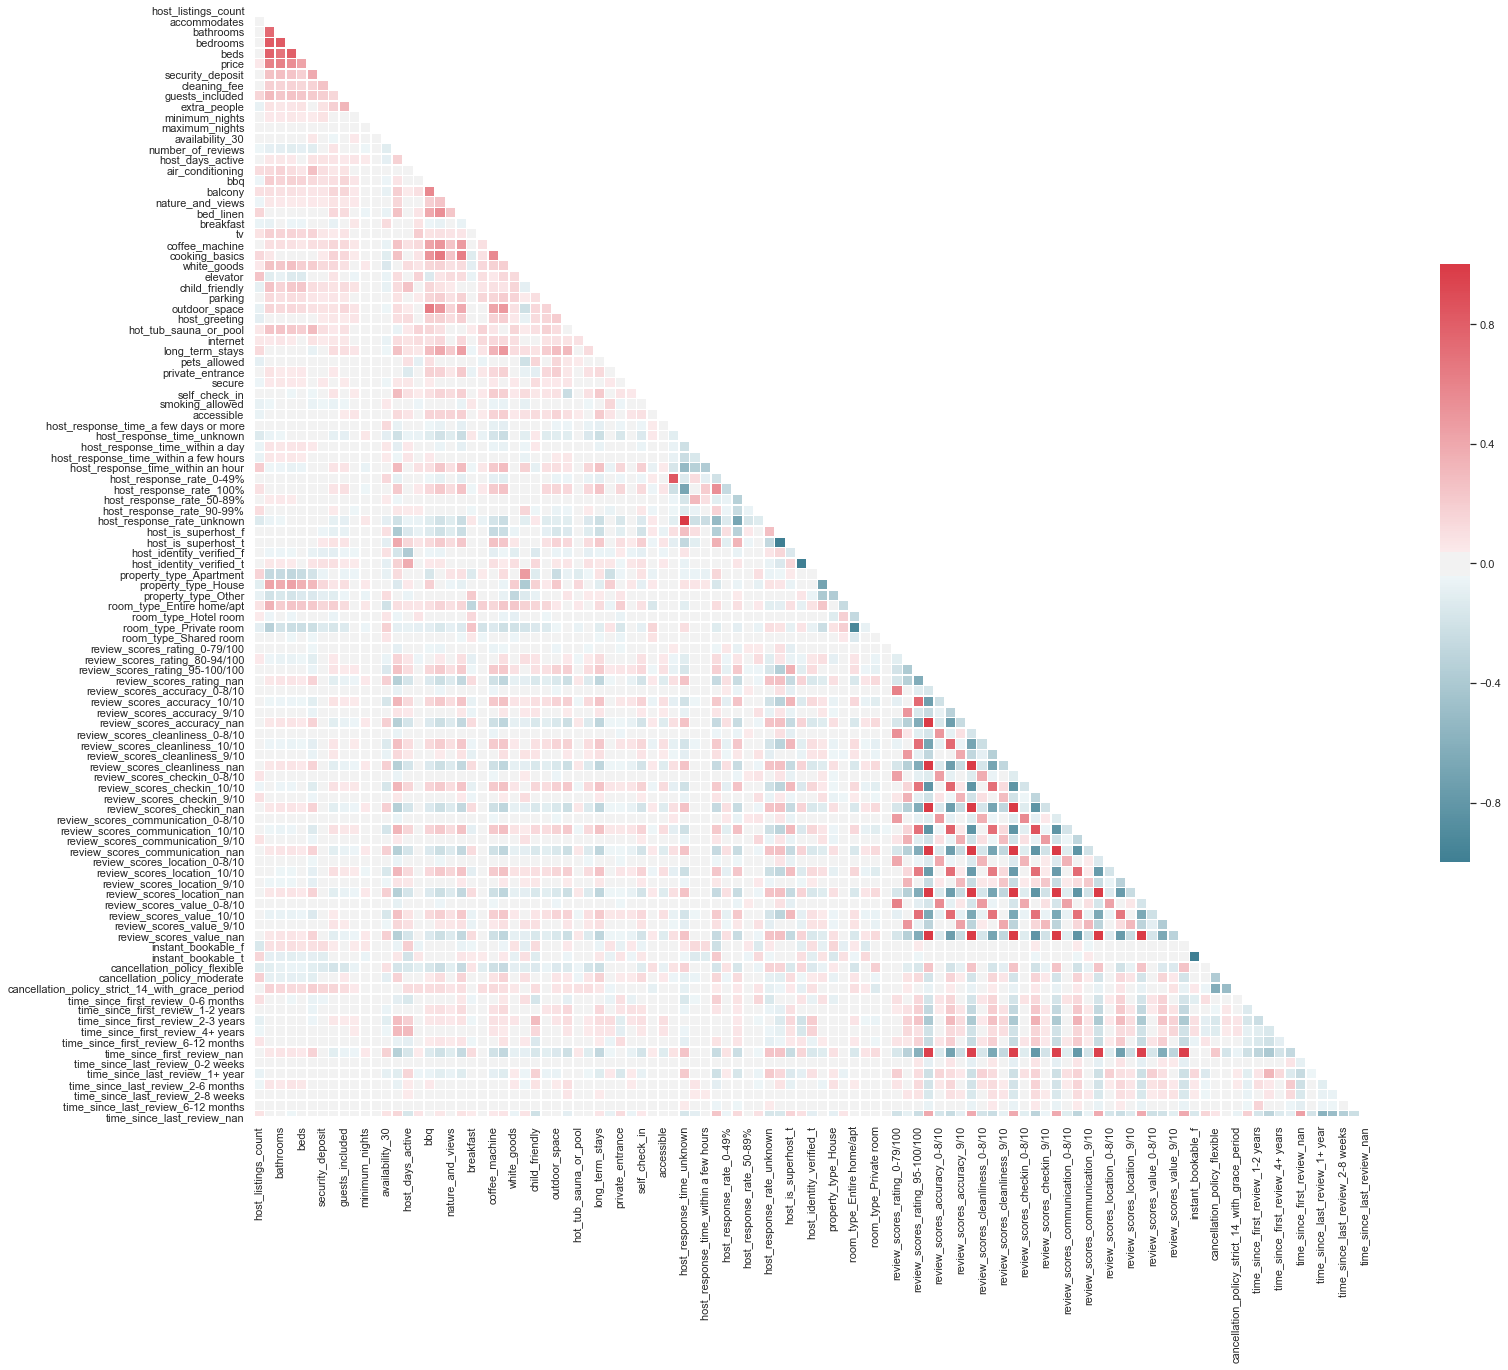

In [286]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood_cleansed')]), axis=1), figsize=(25,22))

In [287]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

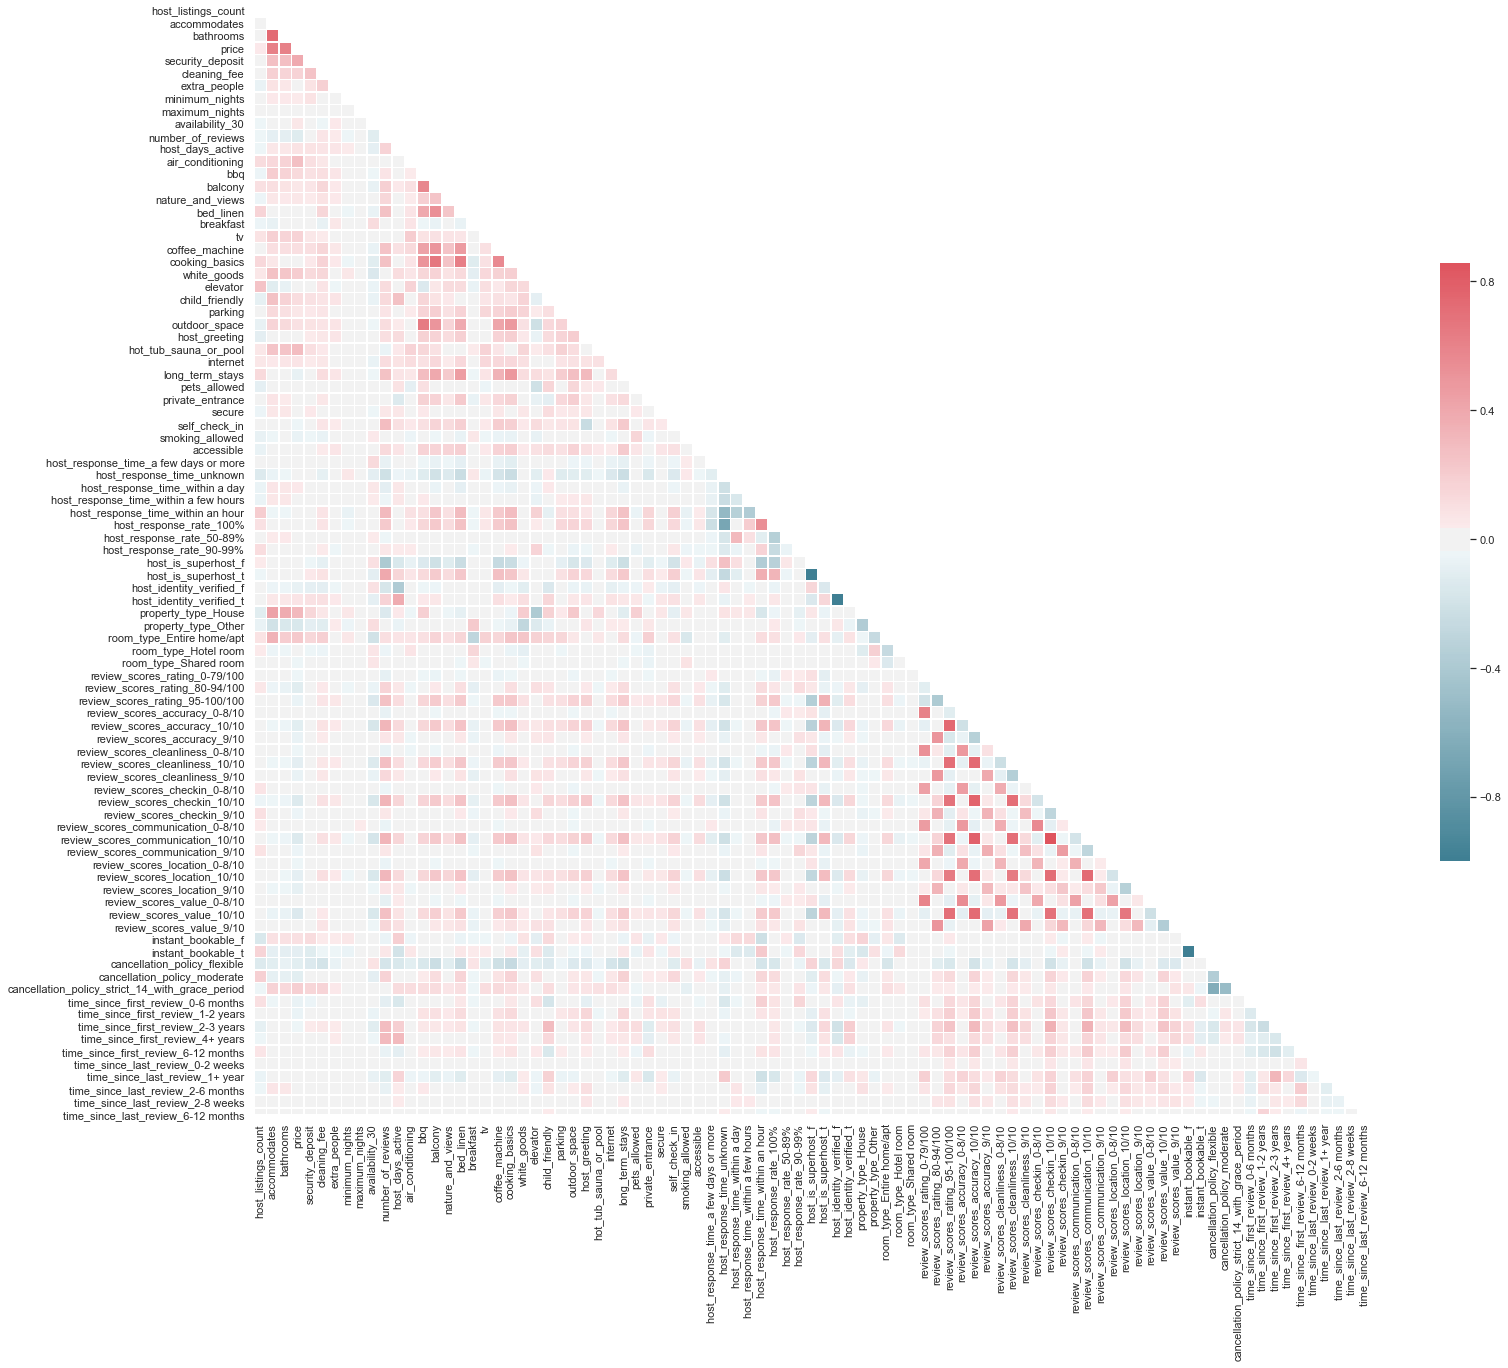

In [288]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood_cleansed')]), axis=1), figsize=(25,22))

Standardising and normalising

In [289]:
numerical_columns = ['accommodates', 'availability_30', 'bathrooms', 'cleaning_fee', 'extra_people', 'host_days_active', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'security_deposit']

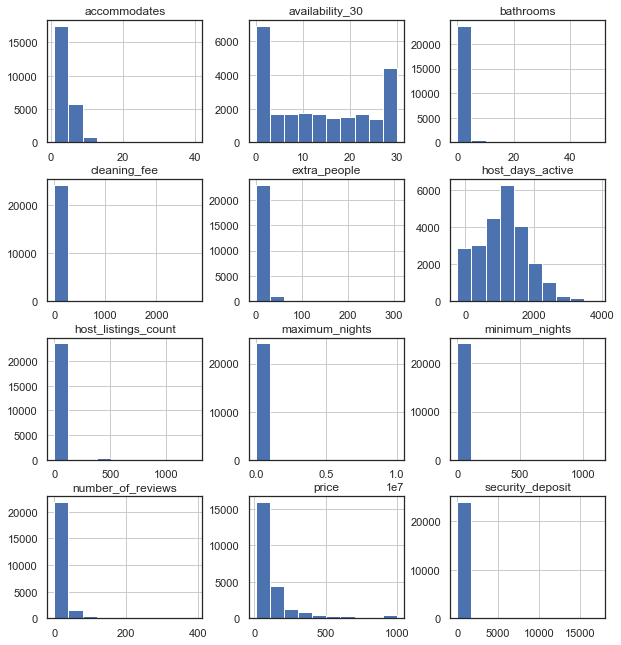

In [290]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [291]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_30', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

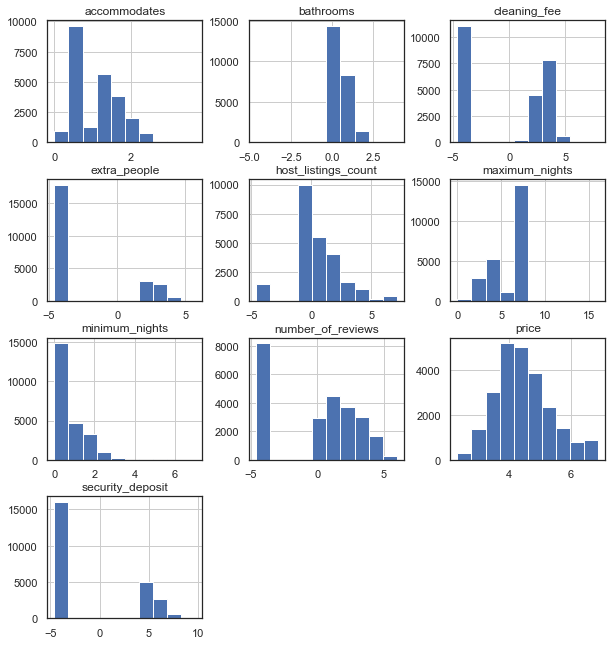

In [292]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [293]:
transformed_df2 = transformed_df.copy

In [294]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# Models 

In [295]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [314]:
hpm_reg_start = time.time()

# Create instance of the model, `LinearRegression` function from 
# Scikit-Learn and fit the model on the training data:

hpm_reg = LinearRegression()  
hpm_reg.fit(X_train, y_train) #training the algorithm

# Now that the model has been fit we can make predictions by calling 
# the predict command. We are making predictions on the testing set:
training_preds_hpm_reg = hpm_reg.predict(X_train)
val_preds_hpm_reg = hpm_reg.predict(X_test)

hpm_reg_end = time.time()

print(f"Time taken to run: {round((hpm_reg_end - hpm_reg_start)/60,1)} minutes")

# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg),4))

Time taken to run: 0.0 minutes

Training RMSE: 0.2316
Validation RMSE: 3.6744757153763725e+24

Training r2: 0.7198
Validation r2: -4.254409251872955e+24


In [315]:

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)


print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

C:\Users\Kwasi\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:58:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Training MSE: 0.2061
Validation MSE: 0.2155

Training r2: 0.7507
Validation r2: 0.7504


In [316]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
neighbourhood_cleansed_Ward 44,0.000000
neighbourhood_cleansed_Ward 55,0.000000
neighbourhood_cleansed_Ward 56,0.000000
neighbourhood_cleansed_Ward 57,0.000000
neighbourhood_cleansed_Ward 58,0.000000
...,...
cancellation_policy_strict_14_with_grace_period,0.041484
neighbourhood_cleansed_Ward 54,0.044969
air_conditioning,0.059730
bathrooms,0.176033


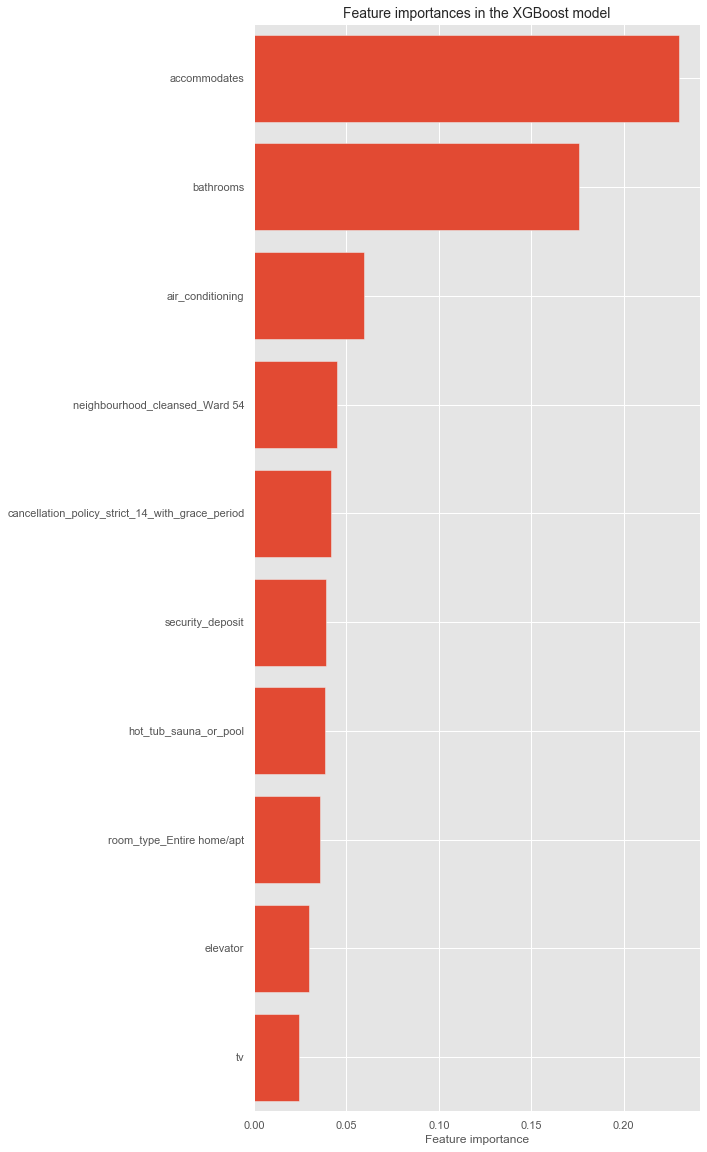

In [317]:
# Plotting feature importances
plt.figure(figsize=(8,20))
n=10
plt.barh(ft_weights_xgb_reg.index[-n:], ft_weights_xgb_reg.weight[-n:], align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [318]:
all_review = list(X_train.columns[X_train.columns.str.startswith("review_scores")])
review_to_keep = list(X_train.columns[X_train.columns.str.startswith("review_scores_rating")])
review_to_drop = [x for x in all_review if x not in review_to_keep]

X_train_short = X_train.drop(review_to_drop, axis=1)
X_test_short = X_test.drop(review_to_drop, axis=1)

In [319]:
xgb_reg_start = time.time()

xgb_reg2 = xgb.XGBRegressor()
xgb_reg2.fit(X_train, y_train)
training_preds_xgb_reg2 = xgb_reg2.predict(X_train)
val_preds_xgb_reg2 = xgb_reg2.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg2),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg2),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg2),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg2),4))

C:\Users\Kwasi\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:58:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.2 minutes

Training MSE: 0.2061
Validation MSE: 0.2155

Training r2: 0.7507
Validation r2: 0.7504


Final model selection

Overall, the XGBoost model is the best model. 